Plant Pathology 2020 - FGVC7 - 
Identify the category of foliar diseases in apple trees
https://www.kaggle.com/c/plant-pathology-2020-fgvc7

In [0]:
import os
from glob import glob
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import PIL.Image as Image
import torch.optim as optim
import torch.functional as F
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torchvision
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import cv2
import torch.utils.data
import torchvision

In [0]:
!pip install pytorch_toolbelt

In [0]:
from pytorch_toolbelt import losses as L

In [0]:
import albumentations as A
from albumentations.pytorch import ToTensor

In [0]:
class PlantDataset(Dataset):
  def __init__(self, data, unb_transforms=None, transforms=None):
    self.data = data
    self.labels = torch.eye(4)[self.data['Target']]
    self.unb_transforms = unb_transforms  # transforms for unbalanced class
    self.transforms = transforms

  def __len__(self):
    return len(self.data) 

  def __getitem__(self, index):
    image = cv2.imread('./plants_pathology2020/images/'+self.data.loc[index]['image_id']+'.jpg')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    label = torch.tensor(self.data.loc[index]['Target'])
    sample = {'images':image, 'labels':label}
    if self.transforms:
      if sample['labels']==1:
        augmented = self.unb_transforms(image=sample['images'])
      augmented = self.transforms(image=sample['images'])
      sample['images'] = augmented['image']

    return sample

In [0]:
# transforms for 1 class
unb_tfs = A.Compose([
    A.Resize(224, 224),
    A.RandomRotate90(),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.HueSaturationValue(hue_shift_limit=(-15,0),sat_shift_limit=0.3,val_shift_limit=0.3,p=0.7),
    A.Normalize(p=1.0),
    ToTensor()
])

# transforms for other classes
tfs =  A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(p=1.0),
    ToTensor()
])

In [0]:
# load csv file
data = pd.read_csv('./plants_pathology2020/train.csv')

In [10]:
data.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [11]:
cols = ['healthy', 'multiple_deseases', 'rust', 'scab']
target = []
for i in tqdm(range(len(data))):
  target.append(cols[np.argmax(data.iloc[i].values[1:])])

100%|██████████| 1821/1821 [00:00<00:00, 4413.63it/s]


In [12]:
data['Target'] = target
le = LabelEncoder()
data['Target'] = le.fit_transform(data['Target'])
data.head()

,image_id,healthy,multiple_diseases,rust,scab,Target
0,Train_0,0,0,0,1,3
1,Train_1,0,1,0,0,1
2,Train_2,1,0,0,0,0
3,Train_3,0,0,1,0,2
4,Train_4,1,0,0,0,0


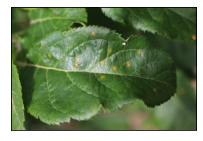

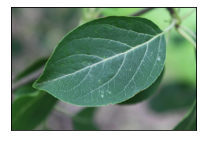

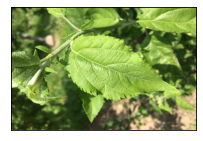

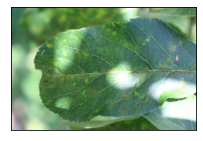

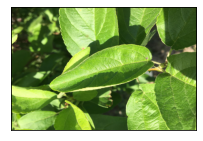

In [13]:
images = glob('./plants_pathology2020/images/*.jpg')
for i in range(5):
  image = Image.open(images[i])
  plt.figure(figsize=(12, 5))
  plt.subplot(2, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(image)

2    622
3    592
0    516
1     91
Name: Target, dtype: int64


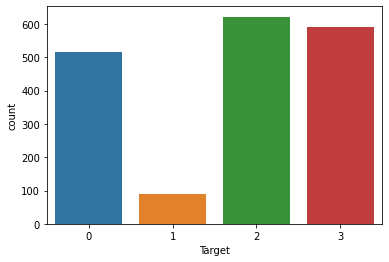

In [14]:
print(data['Target'].value_counts())
sns.countplot(data['Target'])

In [0]:
# load data
train_data = PlantDataset(data, unb_transforms=unb_tfs, transforms=tfs)

In [0]:
# train test split

batch_size = 32

data_size = len(train_data)
val_fraction = 0.2

val_split = int(np.floor((val_fraction) * data_size))
indices = list(range(data_size))
np.random.seed(42)
np.random.shuffle(indices)

train_indices, val_indices = indices[val_split:], indices[:val_split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(train_data, batch_size=batch_size, sampler=val_sampler)

In [0]:
# train function

def compute_accuracy(model, loader):
  model.eval()
  correct_samples = 0
  total_samples = 0
  for i_step, data in enumerate(loader):
    x = data['images'].to(device)
    y = data['labels'].to(device)
    pred = model(x)
    _, indices = torch.max(pred, 1)
    correct_samples += torch.sum(indices==y)
    total_samples += y.shape[0]
  accuracy = float(correct_samples) / total_samples
  return accuracy  


def train_model(model, train_loader, val_loader, loss, optimizer, scheduler, n_epochs):
  loss_history = []
  train_history = []
  val_history = []
  for epoch in range(n_epochs):
    print('Epoch {}'.format(epoch+1))
    model.train()
    loss_accum = 0
    correct_samples = 0
    total_samples = 0
    for i_step, data in enumerate(train_loader):
      x = data['images'].to(device)
      y = data['labels'].to(device)
      optimizer.zero_grad()
      pred = model(x)
      loss_value = loss(pred, y)
      loss_value.backward()
      optimizer.step()
      
      _, indices = torch.max(pred, 1)
      correct_samples += torch.sum(indices==y)
      total_samples += y.shape[0]
      loss_accum += loss_value

    avg_loss = loss_accum / i_step
    train_acc = float(correct_samples) / total_samples
    val_acc = compute_accuracy(model, val_loader)
    scheduler.step(val_acc)
    
    loss_history.append(float(avg_loss))
    train_history.append(train_acc)
    val_history.append(val_acc)

    print('Average loss: %f, Train accuracy: %f, Val accuracy: %f' % 
          (avg_loss, train_acc, val_acc))
  return loss_history, train_acc, val_acc           

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = models.densenet169(pretrained=True)

for param in model.parameters():
  param.trainable = True

n_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(n_ftrs, 1000),
    nn.ReLU(),
    nn.Dropout2d(0.7),
    nn.Linear(1000, 4)
)
cl_params = model.classifier.parameters()
for param in cl_params:
  param.trainable = True

params = [{'params':list(model.parameters())[:-1], 'lr':1e-4},
          {'params':list(model.parameters())[-1:], 'lr':1e-5}]  

model.to(device)
loss = L.FocalLoss()
optimizer = optim.Adam(params, weight_decay=1e-4) 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True, mode='min')

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/checkpoints/densenet169-b2777c0a.pth


In [19]:
loss_history, train_history, val_history = train_model(model, train_loader, val_loader, loss, optimizer, scheduler, 12)

Epoch 1
Average loss: 0.373585, Train accuracy: 0.717914, Val accuracy: 0.912088
Epoch 2
Average loss: 0.137430, Train accuracy: 0.917639, Val accuracy: 0.923077
Epoch 3
Average loss: 0.088584, Train accuracy: 0.944406, Val accuracy: 0.956044
Epoch 4
Average loss: 0.071237, Train accuracy: 0.960879, Val accuracy: 0.947802
Epoch 5
Average loss: 0.048585, Train accuracy: 0.978723, Val accuracy: 0.964286
Epoch 6
Average loss: 0.041590, Train accuracy: 0.974605, Val accuracy: 0.950549
Epoch 7
Epoch     7: reducing learning rate of group 0 to 1.0000e-05.
Epoch     7: reducing learning rate of group 1 to 1.0000e-06.
Average loss: 0.027538, Train accuracy: 0.988332, Val accuracy: 0.958791
Epoch 8
Average loss: 0.020371, Train accuracy: 0.991078, Val accuracy: 0.967033
Epoch 9
Average loss: 0.013972, Train accuracy: 0.993823, Val accuracy: 0.975275
Epoch 10
Average loss: 0.011652, Train accuracy: 0.997255, Val accuracy: 0.969780
Epoch 11
Average loss: 0.010439, Train accuracy: 0.996568, Val ac

In [0]:
class PredictData(Dataset):
    def __init__(self,csv,transforms):
        self.data = csv
        self.transforms = transforms
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
      image = cv2.imread('./plants_pathology2020/images/'+self.data.loc[index]['image_id']+'.jpg')
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      sample = {'images':image}
      if self.transforms:
        augmented = self.transforms(image=sample['images'])
        sample['images'] = augmented['image']

      return sample

In [21]:
test_df = pd.read_csv('./plants_pathology2020/test.csv')
test_df.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


In [0]:
predictionData = PredictData(test_df, tfs)

In [0]:
predictloader = DataLoader(predictionData)

In [24]:
predict = []
for batch_idx, d in tqdm(enumerate(predictloader)):
    data = d['images'].cuda()
    output = model(data)
    output = output.cpu().detach().numpy()
    #output = np.argmax(output)
    predict.append(output)
    #print(output)

1821it [12:16,  2.47it/s]


In [0]:
sample_submission = pd.read_csv('./plants_pathology2020/sample_submission.csv')

In [0]:
sample_submission['healthy'] = healthy
sample_submission['multiple_diseases'] = multiple_disease
sample_submission['rust'] = rust
sample_submission['scab'] = scab

In [28]:
sample_submission.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,-3.490118,-2.705062,2.947175,-3.461752
1,Test_1,-3.572560,-2.733608,2.775006,-3.422974
2,Test_2,-4.069440,-4.227351,-3.686383,3.993049
3,Test_3,4.915645,-4.854841,-4.350522,-5.230927
4,Test_4,-4.449449,-3.871939,4.040623,-4.380485
